In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
# Read the csv files

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
def calculate_six_abs(instrument, x, merged_df):
    temperature_diff = np.abs(merged_df[instrument] - merged_df['Cool Set Temp (F)'])
    return set(merged_df.index[temperature_diff <= x])

def calculate_rix_abs(instrument, x, y, merged_df):
    six_y = calculate_six_abs(instrument, y, merged_df)
    six_x = calculate_six_abs(instrument, x, merged_df)
    si = len(merged_df)
    
    si_y = len(six_y)
    si_x = len(six_x)
    
    rix = (si_y - si_x) / si
    
    return rix

In [10]:

room_name_map = {
     'Basement (F)': 'Basement',
     'Thermostat Temperature (F)':'Thermostat',
     'Living Room (F)': 'Room 1',
     'SunRoom (F)': 'Room 2',
     'BoyRoom (F)': 'Room 3',
     'GirlRoom (F)': 'Room 4',
     'Closet (F)': 'Room 5',
     'Bedroom (F)': 'Room 6',
     'GuestRoom (F)': 'Room 7',
     'Office (F)': 'Room 8',
}

def plot_relative_frequencies(merged_df, rooms, filename='plot.pdf'):
    x_values = np.arange(-math.ceil(abs_max_deviation), math.ceil(abs_max_deviation) + 1, 0.5) 
    plt.figure(figsize=(14, 8))

    all_R_values = {}
    comfort_metrics = {}
    lines = []

    for room, room_name in room_name_map.items():
        if room + "_diff" in merged_df.columns:
            R_values = []
            total_comf = 0
            comfort_2F = 0

            for x in x_values:
                Si_lower = merged_df[merged_df[f'{room}_diff'] <= x - 0.5]
                Si_upper = merged_df[merged_df[f'{room}_diff'] <= x]

                R = (len(Si_upper) - len(Si_lower)) / len(merged_df[f'{room}_diff'].dropna())
                R_values.append(R)

            all_R_values[room_name] = R_values
            total_comf = np.trapz(R_values, x_values)
            comfort_2F = np.trapz([r for x, r in zip(x_values, R_values) if x <= 0], x_values[(x_values <= 0)])

            comfort_metrics[room_name] = comfort_2F / total_comf if total_comf != 0 else 0
            
            # Change color and line width for Thermostat
            if room_name == 'Thermostat':
                # Define the color here, we'll overwrite it later
                line, = plt.plot(x_values, R_values, label=f'{room_name}: {round(comfort_metrics[room_name], 2)}', linewidth=5, color='blue', zorder=10)

                lines.append(line)
                max_y = max(R_values)
                max_x = x_values[R_values.index(max_y)]
                plt.vlines(max_x, 0, max_y, colors='k', linestyles='dashed', linewidth=1)
                plt.xticks(list(set(list(plt.xticks()[0]) + [max_x])))
            else:
                line, = plt.plot(x_values, R_values, label=f'{room_name}: {round(comfort_metrics[room_name], 2)}', linewidth=2.0, zorder=1)
                lines.append(line)
            print(room, comfort_metrics[room_name])

    # Get the color of the basement line (the first line) and make it brighter
    base_color = lines[0].get_color()
    thermostat_color = base_color  # Increase each RGB component, but don't go above 1
    lines[0].set_color('green')  # New color for basement
    lines[1].set_color(thermostat_color)  # Set the color for thermostat

    for room_name, R_values in all_R_values.items():
        plt.fill_between(x_values, R_values, where= (np.array(x_values) <= 0), color='gray', alpha=0.3)

    plt.xlabel('Temperature Deviation (°F)', fontsize=24)
    plt.ylabel('Relative Frequency', fontsize=24)
    #plt.title('Relative Frequencies of Temperature Deviations', fontsize=20)
    plt.legend(title='Comfortable Cooling Index', title_fontsize='20', prop={'size': 20})

    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

    return comfort_metrics



### ANALYSIS OF THE WEEK WHERE AVERAGING WAS WORKING


In [12]:
# Read the csv files
df = pd.read_csv('report_averaging.csv',skiprows=5, index_col=False)

# Convert 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

rooms = ['Thermostat Temperature (F)', 'Living Room (F)', 'SunRoom (F)', 'GirlRoom (F)', 'BoyRoom (F)', 'Bedroom (F)', 'Closet (F)', 'GuestRoom (F)', 'Office (F)', 'Basement (F)']

# Set the start and end dates of the week you want to include
start_date = '2023-06-12'
end_date = '2023-06-18'

# Create a mask for all dates in the range
date_mask = (df['Date'].dt.date.between(pd.to_datetime(start_date).date(), pd.to_datetime(end_date).date()))

# Apply the date mask to the dataframe
df = df.loc[date_mask]

# Calculate the mode of 'Cool Set Temp (F)'
cool_set_temp_mode = df['Cool Set Temp (F)'].mode().iloc[0]

# Create a new DataFrame with only the rows where 'Cool Set Temp (F)' is equal to the mode
merged_df = df[df['Cool Set Temp (F)'] == cool_set_temp_mode]

# Drop rows with NaN values in the specified rooms
merged_df = merged_df.dropna(subset=rooms)

# Filter merged_df such that the mean of 'Outdoor Temp (F)' is above 65 F
merged_df = merged_df[merged_df['Outdoor Temp (F)'] > 65]

# Calculate and print the mean of 'Outdoor Temp (F)'
outdoor_temp_mean = np.mean(merged_df['Outdoor Temp (F)'])
print(f'Mean of Outdoor Temp (F) after filtering: {outdoor_temp_mean}')


Mean of Outdoor Temp (F) after filtering: 72.68666666666667


In [13]:
# Convert 'Time' to datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'], format='%H:%M:%S')

# Extract hour from 'Time'
merged_df['Hour'] = merged_df['Time'].dt.hour

# Calculate total number of unique hours
total_hours = merged_df.groupby(['Date','Hour']).size().reset_index().shape[0]

print(f'Total number of unique hours: {total_hours}')

# Calculate total number of unique days
total_days = merged_df['Date'].nunique()

print(f'Total number of unique days: {total_days}')


Total number of unique hours: 39
Total number of unique days: 6


Basement (F) 1.0
Thermostat Temperature (F) 1.0
Living Room (F) 1.0
SunRoom (F) 0.8425287356321839
BoyRoom (F) 1.0
GirlRoom (F) 1.0
Closet (F) 0.9999999999999999
Bedroom (F) 1.0
GuestRoom (F) 0.8988505747126436
Office (F) 0.8701149425287357


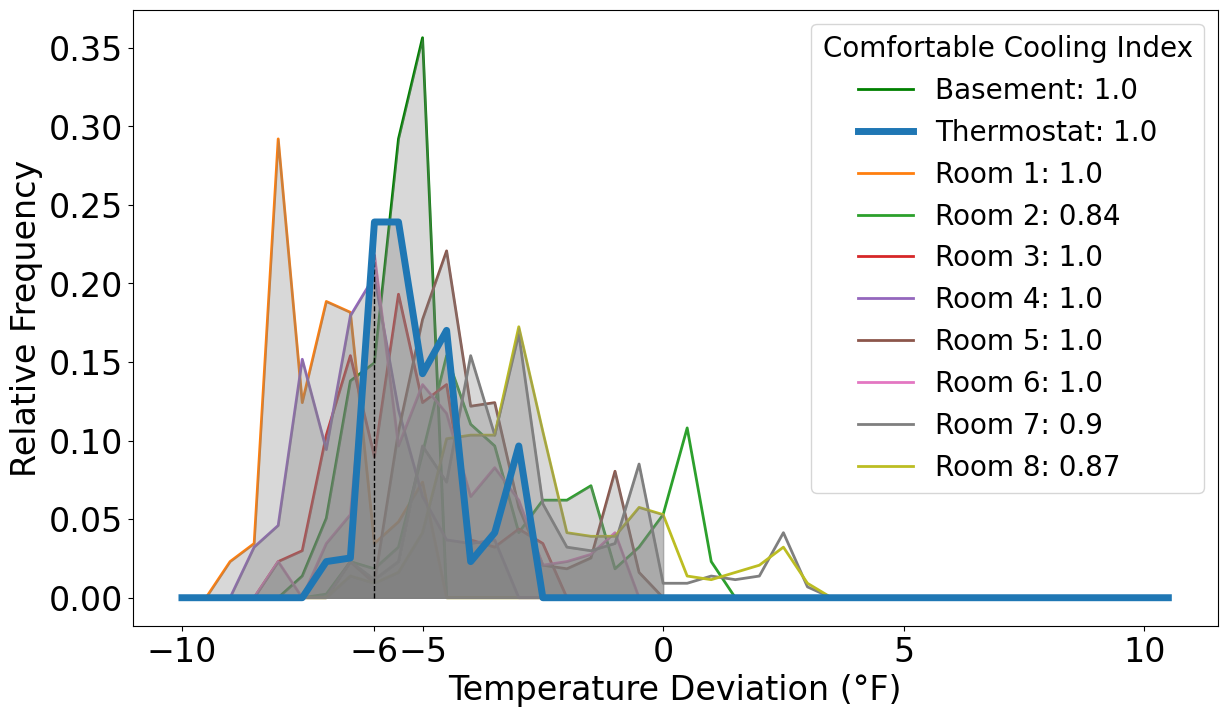

{'Basement': 1.0, 'Thermostat': 1.0, 'Room 1': 1.0, 'Room 2': 0.8425287356321839, 'Room 3': 1.0, 'Room 4': 1.0, 'Room 5': 0.9999999999999999, 'Room 6': 1.0, 'Room 7': 0.8988505747126436, 'Room 8': 0.8701149425287357}


In [15]:

# Calculate the temperature difference for each sensor
for room in rooms:
    merged_df[f'{room}_diff'] = merged_df[room] - merged_df['Cool Set Temp (F)']
# Find absolute maximum deviation
max_deviations = [merged_df[f'{room}_diff'].max() for room in rooms]
min_deviations = [merged_df[f'{room}_diff'].min() for room in rooms]
abs_max_deviation = max(max(max_deviations), abs(min(min_deviations)))

# Now call the function with the merged dataframe and the room names
comfort_metrics = plot_relative_frequencies(merged_df, rooms, filename="averaging.pdf")
print(comfort_metrics)


### ANALYSIS OF THE WEEK WHERE AVERAGING WAS NOT WORKING

In [16]:
#1 week of non-averaging data analysis
# Read the csv files
df = pd.read_csv('report_thermostat.csv',skiprows=5, index_col=False)
# Convert 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Set the start and end dates of the week you want to include
start_date = '2023-06-25'
end_date = '2023-07-10'
# Create a mask for all dates in the range
date_mask = (df['Date'].dt.date.between(pd.to_datetime(start_date).date(), pd.to_datetime(end_date).date()))

# Convert 'Time' column to datetime format if it's not already
df['Time'] = pd.to_datetime(df['Time']).dt.time
#merged_df = df.loc[date_mask]
# Define start and end times
start_time = pd.to_datetime('09:00:00').time()
end_time = pd.to_datetime('16:00:00').time()

# Create a mask for the time outside of the 9 AM to 4 PM range
time_mask = ~df['Time'].between(start_time, end_time)

# Apply the date and time masks to the dataframe
merged_df = df.loc[date_mask & time_mask]
# Calculate the mode of 'Cool Set Temp (F)'
cool_set_temp_mode = df['Cool Set Temp (F)'].mode().iloc[0]
#print(cool_set_temp_mode)
# Create a new DataFrame with only the rows where 'Cool Set Temp (F)' is equal to the mode
merged_df = df[df['Cool Set Temp (F)'] == cool_set_temp_mode]

# Drop rows with NaN values in the specified rooms
merged_df = merged_df.dropna(subset=rooms)
np.mean(merged_df['Outdoor Temp (F)'])


72.56036109971275

In [17]:
# Convert 'Time' to datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'], format='%H:%M:%S')

# Extract hour from 'Time'
merged_df['Hour'] = merged_df['Time'].dt.hour

# Calculate total number of unique hours
total_hours = merged_df.groupby(['Date','Hour']).size().reset_index().shape[0]

print(f'Total number of unique hours: {total_hours}')

# Calculate total number of unique days
total_days = merged_df['Date'].nunique()

print(f'Total number of unique days: {total_days}')


Total number of unique hours: 215
Total number of unique days: 24


Basement (F) 1.0
Thermostat Temperature (F) 0.8812448812448812
Living Room (F) 0.902948402948403
SunRoom (F) 0.7242014742014742
BoyRoom (F) 0.6824324324324325
GirlRoom (F) 0.7059787059787059
Closet (F) 0.5915233415233416
Bedroom (F) 0.6678951678951679
GuestRoom (F) 0.5290745290745291
Office (F) 0.47174447174447165


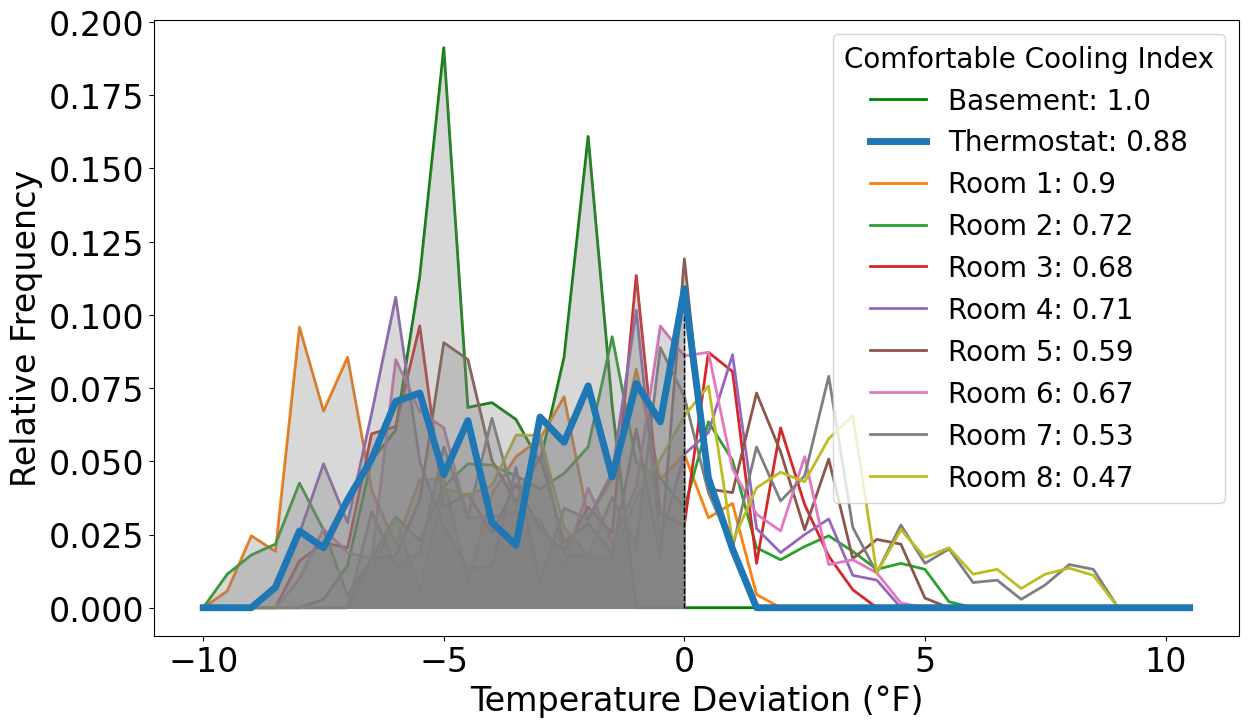

{'Basement': 1.0, 'Thermostat': 0.8812448812448812, 'Room 1': 0.902948402948403, 'Room 2': 0.7242014742014742, 'Room 3': 0.6824324324324325, 'Room 4': 0.7059787059787059, 'Room 5': 0.5915233415233416, 'Room 6': 0.6678951678951679, 'Room 7': 0.5290745290745291, 'Room 8': 0.47174447174447165}


In [18]:

# Calculate the temperature difference for each sensor
for room in rooms:
    merged_df[f'{room}_diff'] = merged_df[room] - merged_df['Cool Set Temp (F)']
# Find absolute maximum deviation
max_deviations = [merged_df[f'{room}_diff'].max() for room in rooms]
min_deviations = [merged_df[f'{room}_diff'].min() for room in rooms]
abs_max_deviation = max(max(max_deviations), abs(min(min_deviations)))

# Now call the function with the merged dataframe and the room names
comfort_metrics = plot_relative_frequencies(merged_df, rooms,filename="thermostat.pdf")
print(comfort_metrics)

In [14]:
# Data
averaging = [1.0, 1.0, 0.8425287356321839, 1.0, 1.0, 1.0, 0.9999999999999999, 0.8988505747126436, 0.8701149425287357]
non_averaging = [0.8812448812448812, 0.902948402948403, 0.7242014742014742, 0.7059787059787059, 0.6824324324324325, 0.6678951678951679, 0.5915233415233416, 0.5290745290745291, 0.47174447174447165]

# Compute improvements
improvements = [(a - n) / n * 100 for a, n in zip(averaging, non_averaging)]

# Compute the average improvement
average_improvement = sum(improvements) / len(improvements)
print(average_improvement)


44.651288676210804
